In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#Step1 : Importing Gravimeter Dataset

data_path = 'C:/Users/k990b708/Desktop/GEOL503_Final_Project/Input/2020_10_23/20201023_gravity_python.txt'

column_names = ['LATITUDE' , 'LONGITUDE' , 'ELEVATION' , 'GRAV_READINGS', 'STD_DEV',
                'TILT_X', 'TILT_Y' , 'TEMPERATURE' , 'TIDE' , 'DURATION' , 'REJECTION' , 
                'TIME' , 'DECIMAL_TIME_AND_DATE' , 'TERRAIN' , 'DATE']

data_file = pd.read_csv(data_path, sep = r'\s+', header = 31, 
                        names = column_names, engine = 'python') 

print(data_file.head())

    LATITUDE  LONGITUDE  ELEVATION  GRAV_READINGS  STD_DEV  TILT_X  TILT_Y  \
0  40.871193  35.468944     719.61       4987.859    0.021    -2.2    -2.2   
1  40.871193  35.468944     719.61       4987.859    0.022    -2.1    -2.6   
2  40.871193  35.468944     719.61       4987.859    0.035    -0.2    -2.8   
3  40.871193  35.468944     719.61       4987.860    0.025    -2.2    -3.2   
4  40.871193  35.468944     719.61       4987.860    0.018    -2.7    -3.2   

   TEMPERATURE   TIDE  DURATION  REJECTION      TIME  DECIMAL_TIME_AND_DATE  \
0        -1.00  0.043        60          0  05:51:24            44096.24364   
1        -1.02  0.042        60          0  05:52:29            44096.24439   
2        -1.04  0.042        60          0  05:53:34            44096.24514   
3        -1.06  0.042        60          1  05:54:39            44096.24589   
4        -1.08  0.041        60          0  05:55:44            44096.24664   

   TERRAIN        DATE  
0      0.0  2020/10/23  
1     

For more information, please check https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [6]:
#Step 2: Filter out data out of standards

filtered_data = data_file[(data_file['STD_DEV'] < 0.100) & #Standard Deviation should smaller than 0.100
                (data_file['DURATION'] >= 60) & #Duration of a reading should be at least 60 seconds or more
                ((data_file['TILT_X'] > -10) & (data_file['TILT_X'] < 10)) & #TiltX should be between -10 and +10
                ((data_file['TILT_Y'] > -10) & (data_file['TILT_Y'] < 10))].copy()  #TiltY should be between -10 and +10

print("Total number of readings in original dataset is" , len(data_file))
print("After filtering out the data out of standards, the remaining number of readings are" , len(filtered_data))

Total number of readings in original dataset is 80
After filtering out the data out of standards, the remaining number of readings are 74


For more information, check https://note.nkmk.me/en/python-pandas-multiple-conditions/

For more information: https://pandas.pydata.org/docs/reference/api/pandas.factorize.html
                      https://stackoverflow.com/questions/16453465/multi-column-factorize-in-pandas

In [7]:
#Step 3: Appoint station number for each location

#Locations = filtered_data[['LATITUDE' , 'LONGITUDE']].drop_duplicates().reset_index(drop = True)

#make a unique string code for each location
coordinates = filtered_data[['LATITUDE', 'LONGITUDE']].astype(str).agg(','.join, axis=1) 
#assign a number of each location using factorize
codes , uniques = pd.factorize(coordinates) 
#appointing a station number in string format for each reading
station_labels = ['ST' + str(i + 1).zfill(5) for i in codes] 
#assign STATION values into a new column
filtered_data.loc[:,'STATION'] = station_labels

print(filtered_data.head())

    LATITUDE  LONGITUDE  ELEVATION  GRAV_READINGS  STD_DEV  TILT_X  TILT_Y  \
0  40.871193  35.468944     719.61       4987.859    0.021    -2.2    -2.2   
1  40.871193  35.468944     719.61       4987.859    0.022    -2.1    -2.6   
2  40.871193  35.468944     719.61       4987.859    0.035    -0.2    -2.8   
3  40.871193  35.468944     719.61       4987.860    0.025    -2.2    -3.2   
4  40.871193  35.468944     719.61       4987.860    0.018    -2.7    -3.2   

   TEMPERATURE   TIDE  DURATION  REJECTION      TIME  DECIMAL_TIME_AND_DATE  \
0        -1.00  0.043        60          0  05:51:24            44096.24364   
1        -1.02  0.042        60          0  05:52:29            44096.24439   
2        -1.04  0.042        60          0  05:53:34            44096.24514   
3        -1.06  0.042        60          1  05:54:39            44096.24589   
4        -1.08  0.041        60          0  05:55:44            44096.24664   

   TERRAIN        DATE  STATION  
0      0.0  2020/10/23

In [8]:
#Step 4: Taking average of some parameters (Longitude, Latitude, Elevation, Time, Date) for each station

# 4.1 Convert Pandas Dataframe format into numpy array
stations  = np.array(filtered_data['STATION'])
latitude  = np.array(filtered_data['LATITUDE'])
longitude = np.array(filtered_data['LONGITUDE'])
elevation = np.array(filtered_data['ELEVATION'])
time_strs = np.array(filtered_data['TIME'])
date_years = np.array(filtered_data['DATE'])

#4.1.1 TIME is in string form (HH:MM:SS) and it needs to be convert into integers in seconds form 

def hms_to_seconds(hms):
    h, m, s = map(int, hms.split(':'))
    return h * 3600 + m * 60 + s

time_seconds = np.array([hms_to_seconds(t) for t in time_strs])

#4.1.2 DATE is also in string form (YEAR/MONTH/DAY) and it needs to be convert into integers as Year, Month & Day 

year = np.array([int(date.split('/')[0]) for date in filtered_data['DATE']])
month = np.array([int(date.split('/')[1]) for date in filtered_data['DATE']])
day = np.array([int(date.split('/')[2]) for date in filtered_data['DATE']])

# 4.2: Create sequential STATION tags for each group
station_tags = [] #an empty list to store station numbers in desired format
counter = 1 #loop preparation for number increment 
previous = None #station number may start from a different number for the other ascii dataset I imported in Step1

for station in stations:
    if station != previous: 
        tag = f"STATION{counter}"
        counter += 1
    station_tags.append(tag) #adding the current tag to the list
    previous = station #keeping the previous number so that loop continues in desired order

station_tags = np.array(station_tags) #creating an array for station tags

# Step 4.3: Preserve original tag order using first appearance
unique_tags, first_indices = np.unique(station_tags, return_index=True) #cancelling the repeated station numbers
ordered_tags = station_tags[np.sort(first_indices)]  # proper order rather than STATION1 , STATION11, STATION12

# Step 4.4: Average latitude, Longitude,Elevation, Time(in seconds) and Date(in years) per tag
avg_lat_output = []
avg_long_output = []
avg_elev_output = []
avg_sec_output = []
avg_date_output = []
combined_output = []

for tag in ordered_tags: 
    mask = station_tags == tag
    avg_lat = np.mean(latitude[mask])
    avg_lat_output.append((tag, avg_lat))
    avg_long = np.mean(longitude[mask])
    avg_long_output.append((tag, avg_long))
    avg_elev = np.round(np.mean(elevation[mask]),2)
    avg_elev_output.append((tag, avg_elev))
    avg_sec = np.round(np.mean(time_seconds[mask]),2)
    avg_sec_output.append((tag,avg_sec))
    avg_year = int(np.mean(year[mask]))
    avg_month = int(np.mean(month[mask]))
    avg_day = int(np.mean(day[mask]))
    date_string = f"{avg_year:04}/{avg_month:02}/{avg_day:02}" #DATE needs to be convert back into string form
    avg_date_output.append((tag, date_string))

#Step4.5: Combine all the results into a single 6-tuples

for i in range(len(ordered_tags)):
    tag = ordered_tags[i]
    lat = avg_lat_output[i][1]
    lon = avg_long_output[i][1]
    elev = avg_elev_output[i][1]
    time_in_sec = avg_sec_output[i][1]
    date = avg_date_output[i][1]
    combined_output.append((tag, lat, lon, elev, time_in_sec, date))

#Step4.6 Display the results

print("{:<10} {:>14} {:>14} {:>14} {:>14} {:>12}".format("STATION", "LATITUDE",
                                                         "LONGITUDE", "ELEVATION", "TIME_SEC", "DATE"))
print("-" * 85)
for tag, lat, lon, elev, time_in_sec, date in combined_output:
    print("{:<10} {:>14.7f} {:>14.7f} {:>14.2f} {:>14.1f} {:>14.10}".format(tag, lat, lon, 
                                                                            elev, time_in_sec, date))

#Step 4.7 Export the results as text file, space delimited 

with open("Averaged_Values.txt", "w") as f:
    f.write("{:<10} {:>9} {:>14} {:>14} {:>14} {:>14}\n".format("#STATION", "LATITUDE", 
                                                                "LONGITUDE" , "ELEVATION", "TIME_SEC", "DATE"))
    f.write("#" * 1 + "-" * 84 + "\n")
    for tag, lat, lon, elev, time_in_sec, date in combined_output:
        f.write("{:<10} {:<14} {:<14} {:<14} {:>8} {:>18}\n".format(tag, lat, lon, elev, time_in_sec, date))

STATION          LATITUDE      LONGITUDE      ELEVATION       TIME_SEC         DATE
-------------------------------------------------------------------------------------
STATION1       40.8711929     35.4689445         719.61        21214.0     2020/10/23
STATION2       40.8631096     35.4121933         740.14        23175.5     2020/10/23
STATION3       40.9389458     35.0011368        1030.05        27579.0     2020/10/23
STATION4       40.9435272     35.0002213        1219.52        28786.0     2020/10/23
STATION5       40.9485550     35.0033875        1090.94        30234.0     2020/10/23
STATION6       40.9429741     35.0144157        1221.73        31562.0     2020/10/23
STATION7       40.9483070     35.0113068        1142.51        32653.0     2020/10/23
STATION8       40.9532204     35.0021095        1027.39        34605.0     2020/10/23
STATION9       40.9622231     35.0026665         825.53        36164.0     2020/10/23
STATION10      40.9595566     35.0056114         808.78 

In [9]:
#Step 5: Computing weighted average of raw gravity readings by using Std. Deviation

# 5.1 Convert Pandas Dataframe format into numpy array
stations  = np.array(filtered_data['STATION'])
raw_readings  = np.array(filtered_data['GRAV_READINGS'])
std_dev_reversed  = 1/ (np.array(filtered_data['STD_DEV']))
product = std_dev_reversed * raw_readings

# 5.2: Create sequential STATION tags for each group
station_tags = [] #an empty list to store station numbers in desired format
counter = 1 #loop preparation for number increment 
previous = None #station number may start from a different number for the other ascii dataset I imported in Step1

for station in stations:
    if station != previous: 
        tag = f"STATION{counter}"
        counter += 1
    station_tags.append(tag) #adding the current tag to the list
    previous = station #keeping the previous number so that loop continues in desired order

station_tags = np.array(station_tags) #creating an array for station tags

# Step 5.3: Preserve original tag order using first appearance
unique_tags, first_indices = np.unique(station_tags, return_index=True) #cancelling the repeated station numbers
ordered_tags = station_tags[np.sort(first_indices)]  # proper order rather than STATION1 , STATION11, STATION12

# Step 5.4: Average latitude, Longitude,Elevation, Time(in seconds) and Date(in years) per tag
weighted_avg_output = []
combined_weighted_output = []

for tag in ordered_tags: 
    mask = station_tags == tag
    sum_std_dev_reversed = np.sum(std_dev_reversed[mask])
    sum_product = np.sum(product[mask])
    weighted_avg_grav = sum_product / sum_std_dev_reversed
    weighted_avg_output.append((tag, weighted_avg_grav))

#Step5.5: Combine all the results into a single 6-tuples

for i in range(len(ordered_tags)):
    tag = ordered_tags[i]
    rel_grav = weighted_avg_output[i][1] #relative gravity readings before processing into observed gravity
    combined_weighted_output.append((tag, rel_grav))


#Step5.6 Display the results

print("{:<10} {:>14}".format("STATION", "RELATIVE_GRAV"))
print("-" * 30)
for tag, rel_grav in combined_weighted_output:
    print("{:<10} {:>14.3f} ".format(tag, rel_grav))

#Step 5.7 Export the results as text file, space delimited 

with open("Weighted_Average_Values.txt", "w") as f:
    f.write("{:<10} {:>15}\n".format("#STATION", "RELATIVE_GRAV"))
    f.write("#" + "-" * 28 + "\n")
    for tag, rel_grav in combined_weighted_output:
        f.write("{:<10} {:>12.3f}\n".format(tag, rel_grav))

STATION     RELATIVE_GRAV
------------------------------
STATION1         4987.859 
STATION2         4977.175 
STATION3         4898.894 
STATION4         4909.871 
STATION5         4937.191 
STATION6         4912.854 
STATION7         4926.724 
STATION8         4950.403 
STATION9         4990.992 
STATION10        4992.623 
STATION11        5002.042 
STATION12        4980.669 
STATION13        5005.692 
STATION14        5011.272 
STATION15        4977.150 
STATION16        4987.831 


In [10]:
#Step 6: Extracting Measured Pressure and Equipment Height for each station and combining the computed values from Step 4 and 5

#6.1 Extracting Measured Pressure and Equiment Height 

#6.1.1 Data Import 

metadata_lines = []
data_path = 'C:/Users/k990b708/Documents/GitHub/Bakioglu_GEOL503_Final_Project/Input/2020_10_23/23.10.2020_gravity.txt'

with open(data_path, "r") as f:
    for line in f:
        if line.startswith("#") and line.count("#") >= 4: #to ensure there is only 4 parameters to import  
            parts = line.strip().split("#") #splits the string into 4 pieces by splitting with each hashtags
            if len(parts) >= 5:
                equipment_height = float(parts[2])  # converting strings into float and eq_height is at index 2 now
                pressure = float(parts[4])          # converting strings into float and pressure is at index 4 now
                metadata_lines.append((equipment_height, pressure))

#6.1.2 Display the results

print("{:<10} {:>14}".format("EQ_HEIGHT", "PRESSURE"))
print("-" * 30)
for equipment_height, pressure in metadata_lines:
    print("{:<10.2f} {:>14.3f} ".format(equipment_height, pressure))

#6.1.3 Export the results into a text file 

with open("Operational_Measurements.txt", "w") as f:
    f.write("{:<10} {:>15}\n".format("#EQ_HEIGHT", "PRESSURE"))
    f.write("#" + "-" * 28 + "\n")
    for equipment_height, pressure in metadata_lines:
        f.write("{:<10.2f} {:>14.3f}\n".format(equipment_height, pressure))

#6.2 Import 3 text files and merging them into one single text file 

#6.2.1 Import the files 

averaged_file = pd.read_csv("Averaged_Values.txt", sep = r'\s+', comment="#", header=None)
weighted_average_file = pd.read_csv("Weighted_Average_Values.txt", sep = r'\s+', comment="#", header=None)
operational_values_file = pd.read_csv("Operational_Measurements.txt", sep = r'\s+', comment="#", header=None)

#6.2.2 Assign Columns 

averaged_file.columns = ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TIME_SEC', 'DATE']
averaged_file['LATITUDE'] = averaged_file['LATITUDE'].map("{:.7f}".format)
averaged_file['LONGITUDE'] = averaged_file['LONGITUDE'].map("{:.7f}".format)

weighted_average_file.columns = ['STATION', 'RELATIVE_GRAV']
operational_values_file.columns = ['EQ_HEIGHT', 'PRESSURE']

#6.2.3 Merge the three files with the selected columns 

merged_file = pd.concat([averaged_file, weighted_average_file['RELATIVE_GRAV'], operational_values_file], axis=1)

#6.2.4 Export into a single text file 

merged_file.to_csv("Merged_Gravity_Data.txt", sep=' ', index=False, float_format="%.3f")

EQ_HEIGHT        PRESSURE
------------------------------
26.20             944.900 
25.90             942.500 
23.90             884.300 
23.40             890.000 
24.90             903.600 
24.70             890.000 
26.50             898.100 
24.40             910.000 
24.90             931.400 
26.40             933.000 
25.90             937.500 
24.40             925.000 
27.90             938.100 
25.70             939.900 
26.90             939.400 
27.20             941.400 


In [11]:
#Step 7: Static Drift Correction 

#7.1 Extract the initiation time (t0) and the static drift rate 

drift_value = None
drift_time_start = None
data_path = 'C:/Users/k990b708/Documents/GitHub/Bakioglu_GEOL503_Final_Project/Input/2020_10_23/23.10.2020_gravity.txt'

with open(data_path, "r") as f:
    for line in f:
        if "Drift:" in line and "DriftTime" not in line:
            # Extract the static drift rate
            drift_value = float(line.strip().split(":")[1].strip())
        elif "DriftTime Start:" in line:
            # Extract the initiation time (t0)
            drift_time_start = line.strip().split(":",1)[1].strip()

#7.2 Convert initiation time into seconds 

def hms_to_seconds(hms):
    h, m, s = map(int, hms.split(':'))
    return h * 3600 + m * 60 + s

delta_t0 = hms_to_seconds(drift_time_start)

# 7.3 Display the values
print("Drift Value:", drift_value)
print("Drift Start Time:", drift_time_start)
print("Drift Start Time in seconds:", delta_t0)

#7.4 Compute the static drift 

#7.4.1 Import the merged gravity text file and assign the columns 

merged_file = pd.read_csv("Merged_Gravity_Data.txt", sep = r'\s+', comment="#", header=0)

#7.4.2 Estimate the static drift 

time_sec = np.array(merged_file['TIME_SEC'])
rel_grav = np.array(merged_file['RELATIVE_GRAV'])
delta_t_in_hrs = (time_sec - delta_t0)/3600 #time in seconds converted into hours 
static_drift = (drift_value/24) * delta_t_in_hrs

#7.4.3 Apply Static Drift Correction

SD_Corr_Gravity = rel_grav - static_drift

#7.4.4 Include the new values into the merged file as columns

merged_file['DELTA_T_HRS'] = delta_t_in_hrs
merged_file['STATIC_DRIFT'] = static_drift
merged_file['STATIC_DRIFT_CORR_GRAV'] = SD_Corr_Gravity

#7.4.5 Display the results 

print(merged_file[['RELATIVE_GRAV', 'TIME_SEC', 'DELTA_T_HRS', 'STATIC_DRIFT', 'STATIC_DRIFT_CORR_GRAV']])

Drift Value: 0.63
Drift Start Time: 05:44:18
Drift Start Time in seconds: 20658
    RELATIVE_GRAV  TIME_SEC  DELTA_T_HRS  STATIC_DRIFT  STATIC_DRIFT_CORR_GRAV
0        4987.859   21214.0     0.154444      0.004054             4987.854946
1        4977.175   23175.5     0.699306      0.018357             4977.156643
2        4898.894   27579.0     1.922500      0.050466             4898.843534
3        4909.871   28786.0     2.257778      0.059267             4909.811733
4        4937.191   30234.0     2.660000      0.069825             4937.121175
5        4912.854   31562.0     3.028889      0.079508             4912.774492
6        4926.724   32653.0     3.331944      0.087464             4926.636536
7        4950.403   34605.0     3.874167      0.101697             4950.301303
8        4990.992   36164.0     4.307222      0.113065             4990.878935
9        4992.623   37496.0     4.677222      0.122777             4992.500223
10       5002.042   38961.0     5.084167      0.133

In [12]:
#Step 8: Equipment Height Correction

#8.1 Import necessary parameters 

eq_height_meters = np.array(merged_file['EQ_HEIGHT']) / 100 #Equipment height values were in cm. Needs to be converted into meters 

#8.2 Compute free-air effects from equipment height

eq_height_free_air_effects = 0.3086 * eq_height_meters 

#8.3 Compute equipment height corrected gravity

eq_height_corr_gravity = SD_Corr_Gravity + eq_height_free_air_effects

#8.4 Include the new values into the merged file as columns

merged_file['EQ_HEIGHT_FREEAIR'] = eq_height_free_air_effects
merged_file['EQ_HEIGHT_CORR_GRAV'] = eq_height_corr_gravity

#8.5 Display the results 

print(merged_file[['STATIC_DRIFT_CORR_GRAV', 'EQ_HEIGHT', 'EQ_HEIGHT_FREEAIR', 'EQ_HEIGHT_CORR_GRAV']])

    STATIC_DRIFT_CORR_GRAV  EQ_HEIGHT  EQ_HEIGHT_FREEAIR  EQ_HEIGHT_CORR_GRAV
0              4987.854946       26.2           0.080853          4987.935799
1              4977.156643       25.9           0.079927          4977.236571
2              4898.843534       23.9           0.073755          4898.917290
3              4909.811733       23.4           0.072212          4909.883946
4              4937.121175       24.9           0.076841          4937.198016
5              4912.774492       24.7           0.076224          4912.850716
6              4926.636536       26.5           0.081779          4926.718315
7              4950.301303       24.4           0.075298          4950.376602
8              4990.878935       24.9           0.076841          4990.955777
9              4992.500223       26.4           0.081470          4992.581693
10             5001.908541       25.9           0.079927          5001.988468
11             4980.526178       24.4           0.075298        

In [13]:
#Step 9 : Atmospheric Pressure Correction 

#9.1 Import necessary parameters 

elevation = np.array(merged_file['ELEVATION'])
pressure = np.array(merged_file['PRESSURE'])

#9.2 Compute the expected atmospheric pressure in the station elevation

Pn = 1013.25 * (1 - ((0.0065*elevation)/288.15))**5.2559

#9.3 Compute the gravity effect of Athmospheric Pressure Difference 

Pgrav = (Pn - pressure) * 3e-4

#9.4 Apply atmospheric pressure correction

Pcorr_Grav = eq_height_corr_gravity + Pgrav

#9.5 Include the new values into the merged file as columns

merged_file['P_NORMAL'] = Pn
merged_file['P_GRAV'] = Pgrav
merged_file['PCORR_GRAV'] = Pcorr_Grav

#9.6 Display the results 

print(merged_file[['EQ_HEIGHT_CORR_GRAV', 'ELEVATION', 'P_NORMAL', 'P_GRAV', 'PCORR_GRAV']])

    EQ_HEIGHT_CORR_GRAV  ELEVATION    P_NORMAL    P_GRAV   PCORR_GRAV
0           4987.935799     719.61  929.735869 -0.004549  4987.931250
1           4977.236571     740.14  927.437800 -0.004519  4977.232052
2           4898.917290    1030.05  895.474137  0.003352  4898.920642
3           4909.883946    1219.52  875.070760 -0.004479  4909.879467
4           4937.198016    1090.94  888.875542 -0.004417  4937.193599
5           4912.850716    1221.73  874.835014 -0.004549  4912.846166
6           4926.718315    1142.51  883.317792 -0.004435  4926.713881
7           4950.376602    1027.39  895.763301 -0.004271  4950.372331
8           4990.955777     825.53  917.928786 -0.004041  4990.951735
9           4992.581693     808.78  919.787810 -0.003964  4992.577730
10          5001.988468     765.17  924.642239 -0.003857  5001.984611
11          4980.601477     877.02  912.233131 -0.003830  4980.597646
12          5005.627490     754.39  925.845403 -0.003676  5005.623814
13          5011.191

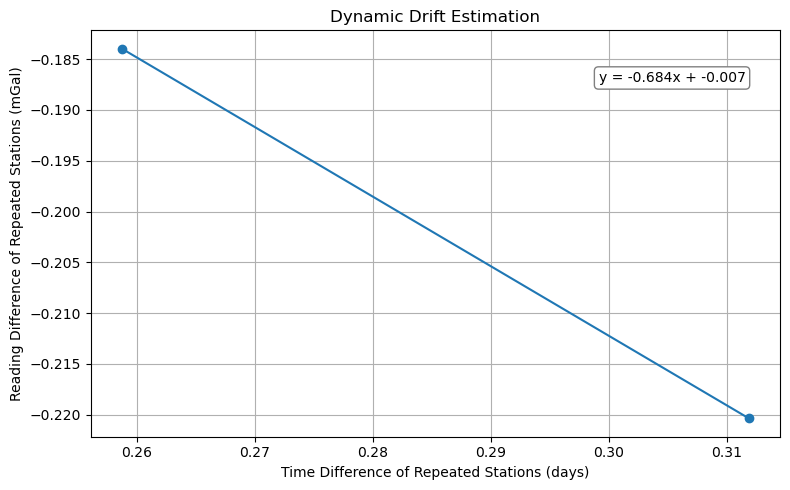

-0.6842176707877005 x + -0.006955491443402423
     PCORR_GRAV  TIME_SEC  DYN_DELTA_T_HRS  DYN_DRIFT  DYNAMIC_DRIFT_CORR_GRAV
0   4987.931250   21214.0         0.000000  -0.000000              4987.924294
1   4977.232052   23175.5         0.544861  -0.015533              4977.240630
2   4898.920642   27579.0         1.768056  -0.050406              4898.971048
3   4909.879467   28786.0         2.103333  -0.059964              4909.939431
4   4937.193599   30234.0         2.505556  -0.071431              4937.265030
5   4912.846166   31562.0         2.874444  -0.081948              4912.928114
6   4926.713881   32653.0         3.177500  -0.090588              4926.804468
7   4950.372331   34605.0         3.719722  -0.106046              4950.478376
8   4990.951735   36164.0         4.152778  -0.118392              4991.070127
9   4992.577730   37496.0         4.522778  -0.128940              4992.706670
10  5001.984611   38961.0         4.929722  -0.140542              5002.125152
11  49

In [14]:
#Step 10: Dynamic Drift Correction

#10.1 Import necessary parameters 

time_sec = np.array(merged_file['TIME_SEC'])
Pcorr_Grav = np.array(merged_file['PCORR_GRAV'])

#10.2 Get the time differences and measurement differences in the repeated stations (BaseStation, RepeatedStation)

base_delta_t = ((time_sec[-1] - time_sec[0])/3600)/24 #time difference in base station (in hours)
repeat_delta_t = ((time_sec[-2] - time_sec[1])/3600)/24 #time difference in repeated station (in hours)
base_grav_diff = Pcorr_Grav[-1] - Pcorr_Grav[0] #measurement difference in base station
repeat_grav_diff = Pcorr_Grav[-2] - Pcorr_Grav[1] #measurement difference in repeated station 

#10.3 Estimate the slope 

#10.3.1 Prepare the x and y series 

time_diff_series = np.array([base_delta_t, repeat_delta_t]) #x-series
grav_diff_series = np.array([base_grav_diff, repeat_grav_diff]) #y-series

#10.3.2 Build the regression matrix 

reg_matrix = np.vstack([time_diff_series, np.ones_like(time_diff_series)]).T

#10.3.3 Solve for Slope and Intercept (ax + b) 

dyn_drift_rate, intercept = np.linalg.lstsq(reg_matrix, grav_diff_series, rcond = None)[0]

#10.3.4 Plot & Graph the Slope and Intercept

plt.figure(figsize=(8, 5))
plt.plot(time_diff_series, grav_diff_series, 'o-')
plt.xlabel('Time Difference of Repeated Stations (days)')
plt.ylabel('Reading Difference of Repeated Stations (mGal)')
plt.title('Dynamic Drift Estimation')
plt.grid(True)

# Equation annotation (formatted)
equation_text = f"y = {dyn_drift_rate:.3f}x + {intercept:.3f}"
plt.text(0.95, 0.90, equation_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         ha='right',
         va='top',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'))
plt.tight_layout()
plt.show()

print(dyn_drift_rate, "x +", intercept)

#10.4 Estimate the dynamic drift effect per station 

dyn_delta_t_in_hrs = (time_sec - time_sec[0])/3600 
dynamic_drift = (dyn_drift_rate/24) * dyn_delta_t_in_hrs

#10.5 Calculate dynamic drift correction

DD_Corr_Gravity = Pcorr_Grav - dynamic_drift

#10.6 Include the new values into the merged file as columns

merged_file['DYN_DELTA_T_HRS'] = dyn_delta_t_in_hrs
merged_file['DYN_DRIFT'] = dynamic_drift
merged_file['DYNAMIC_DRIFT_CORR_GRAV'] = DD_Corr_Gravity

#10.7 Include intercept for QC 

for i in [0, 1]:
    merged_file.loc[i, 'DYNAMIC_DRIFT_CORR_GRAV'] += intercept

#10.8 Display the results

print(merged_file[['PCORR_GRAV', 'TIME_SEC', 'DYN_DELTA_T_HRS', 'DYN_DRIFT', 'DYNAMIC_DRIFT_CORR_GRAV']])

print(DD_Corr_Gravity[-1] - DD_Corr_Gravity[0] == DD_Corr_Gravity[-2] - DD_Corr_Gravity[1])

In [15]:
#Step 11: Base Tie / Convert relative values into absolute gravity values (Observed Gravity)

#11.1 Import the relative gravity values 

DD_Corr_Gravity = merged_file['DYNAMIC_DRIFT_CORR_GRAV'] 

#11.2 Introduce Base Station Absolute Value 

Abs_Base_Station = 980052.595 #mGal

#11.3 Calculating Observed Gravity

Obs_Gravity = DD_Corr_Gravity - DD_Corr_Gravity[0] + Abs_Base_Station

#11.4 Include the observed gravity values into the merged file as a column

merged_file['OBS_GRAV'] = Obs_Gravity

#11.5 Display the results 

# print(merged_file[['STATION' , 'LATITUDE' , 'LONGITUDE' , 'ELEVATION' , 'TIME_SEC' , 'DATE', 'DYNAMIC_DRIFT_CORR_GRAV', 'OBS_GRAV']])
print(merged_file[['STATION' , 'DYNAMIC_DRIFT_CORR_GRAV', 'OBS_GRAV']])

      STATION  DYNAMIC_DRIFT_CORR_GRAV       OBS_GRAV
0    STATION1              4987.924294  980052.595000
1    STATION2              4977.240630  980041.911336
2    STATION3              4898.971048  979963.641753
3    STATION4              4909.939431  979974.610137
4    STATION5              4937.265030  980001.935736
5    STATION6              4912.928114  979977.598820
6    STATION7              4926.804468  979991.475174
7    STATION8              4950.478376  980015.149082
8    STATION9              4991.070127  980055.740833
9   STATION10              4992.706670  980057.377376
10  STATION11              5002.125152  980066.795858
11  STATION12              4980.748356  980045.419062
12  STATION13              5005.782981  980070.453687
13  STATION14              5011.357096  980076.027802
14  STATION15              4977.240630  980041.911336
15  STATION16              4987.924294  980052.595000


In [18]:
#Step 12: Export a text file with the necessary parameters so that the output could be used for Post Processing

export_database = merged_file[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TIME_SEC', 'DATE', 'OBS_GRAV']]

export_subset = export_database.iloc[2:-2].copy() #The first and last two columns are only for base tie and drift estimation. So they will rule out

export_subset['LATITUDE'] = export_subset['LATITUDE'].map("{:.7f}".format) #Latitude is vital and should be as precise as possible for lat correction
export_subset['LONGITUDE'] = export_subset['LONGITUDE'].map("{:.7f}".format) # Longitude is vital with latitude for UTM Conversion in post-processing

export_subset.to_csv("C:/Users/k990b708/Documents/GitHub/Bakioglu_GEOL503_Final_Project/Input/2020_10_23/PreProcessed_Gravity_20201023.txt", 
                     sep=' ', index=False, float_format="%.3f")
